In [1]:
import pandas as pd
import numpy as np
import pyabf
import matplotlib.pyplot as plt
from scipy import stats, signal, optimize

In [44]:
    def Analyse_IntrinsicProfile(V,I,t,sr):

        #Start-end current command
        dI = np.insert(np.diff(I),0,0)
        I_peaks,_ = signal.find_peaks(dI,height=10)
        if np.shape(I_peaks)[0]:
            I_ON = np.argmax(dI)
            I_OFF = np.argmin(dI)

            if I_ON > I_OFF: #Invert ON and OFF for negative current steps
                I_OFF = np.argmax(dI)
                I_ON = np.argmin(dI)

            commandDuration=t[I_OFF]-t[I_ON]
            I_command=np.round(np.mean(I[I_ON+int(0.1*sr):I_ON+int(0.2*sr)])-np.mean(I[I_ON-int(0.2*sr):I_ON-int(0.1*sr)]))

            # Find hyperpolarization-induced voltage sag
            if I_command < 0:
                V_Ih_inst_idx = np.argmin(V[I_ON:I_OFF])+I_ON
                V_Ih_inst = V[V_Ih_inst_idx]
                V_Ih_ss = V[I_OFF]
                V_Ih = V_Ih_ss - V_Ih_inst

            else:
                V_Ih = np.nan
                V_Ih_ss = np.nan

        else:
            commandDuration = 0.5
            I_command = 0
            I_ON = int(0.5*sr)
            V_Ih = np.nan
            V_Ih_ss = np.nan

        #Find resting membrane potential
        RMP = np.mean(V[0:I_ON-int(0.05*sr)])

        #Find firing frequency: number action potentials (APs)
        V_peaks, _ = signal.find_peaks(V,height=-20)
        AP_firingFrequency = np.shape(V_peaks)[0]/commandDuration

        if np.shape(V_peaks)[0] != 0:
        #Find firing frequency adaptation
            adaptationWindow = 0.1
            spikeN_i = np.count_nonzero((V_peaks-I_ON)<adaptationWindow *sr)
            spikeN_f = np.count_nonzero(((V_peaks-I_ON)>(commandDuration-adaptationWindow)*sr) & ((V_peaks-I_ON)<commandDuration*sr))
            if spikeN_i != 0:
                AP_adaptation = (spikeN_i-spikeN_f)/spikeN_i*100
            else:
                AP_adaptation  = np.nan

        else:
            AP_adaptation  = np.nan
        
        if np.shape(V_peaks)[0] in [1,2,3]:

            if np.shape(V_peaks)[0] in [2,3]:
                end_idx = (V_peaks)[1]
            else:
                end_idx = I_OFF

            #Find rheobase
            rheobase = I_command 
            AP_threshold, AP_spikeHeight, AP_halfWidth, AP_fAHP = Analyse_Spike(V, t, sr, V_peaks[0], end_idx)

        else:
            rheobase = np.nan
            AP_threshold = np.nan
            AP_spikeHeight = np.nan
            AP_halfWidth = np.nan
            AP_fAHP = np.nan

        return [commandDuration,I_command,RMP,AP_firingFrequency,V_Ih,V_Ih_ss,rheobase,AP_threshold,AP_spikeHeight,AP_halfWidth,AP_fAHP,AP_adaptation]


In [45]:
    def Analyse_Spike(V, t, sr, spikeIdx, fAHP_end_idx):
        
        #Find AP threshold: first derivative method, 20 % peak velocity cut-off
        dV = np.insert(np.diff(V,n=1),0,0)
        dV_peaks, _ = signal.find_peaks(dV,height=2)
        Th_idx = np.argmin(abs(dV[dV_peaks[0]-int(0.005*sr):dV_peaks[0]]-dV[dV_peaks][0]*0.20))+dV_peaks[0]-int(0.005*sr)
        AP_threshold = V[Th_idx]
        
        #Find AP height
        AP_peakHeight = V[spikeIdx]
        AP_spikeHeight = AP_peakHeight-AP_threshold

        #Find spike half-width
        AP_halfHeigth = AP_spikeHeight/2
        Half_Start = np.argmin(abs(V[Th_idx:spikeIdx]-(AP_peakHeight-AP_halfHeigth)))+Th_idx
        Half_End = np.argmin(abs(V[spikeIdx:fAHP_end_idx]-(AP_peakHeight-AP_halfHeigth)))+spikeIdx
        AP_halfWidth = t[Half_End]-t[Half_Start]

        #Find fast AHP (fAHP) amplitude
        fAHP_idx = np.argmin(V[spikeIdx:fAHP_end_idx])+spikeIdx
        AP_fAHP = AP_threshold - V[fAHP_idx]
        
        return(AP_threshold, AP_spikeHeight, AP_halfWidth, AP_fAHP)

In [46]:
    def Analyse_Rin(V, I, t, sr):
        
        #Start-end current command
        dI = np.insert(np.diff(I),0,0)
        I_peaks,_ = signal.find_peaks(dI,height=5)
        if np.shape(I_peaks)[0]:
            I_ON = np.argmax(dI)
            I_OFF = np.argmin(dI)

            if I_ON > I_OFF: #Invert ON and OFF for negative current steps
                I_OFF = np.argmax(dI)
                I_ON = np.argmin(dI)

            commandDuration=t[I_OFF]-t[I_ON]
            deltaI=np.round(np.mean(I[I_ON+int(0.1*sr):I_ON+int(0.2*sr)])-np.mean(I[I_ON-int(0.2*sr):I_ON-int(0.1*sr)]))
            
        #Find input resistance (Rin) in MOhm
            deltaV = np.mean(V[I_ON-int(0.05*sr):I_ON])-np.mean(V[I_OFF-int(0.05*sr):I_OFF])  
            Rin = abs(deltaV/deltaI*1000)
                
        #Find decay time constant
            def mono_exp(x, a, b):
                return a * np.exp(b * x) 

            xfit = t[I_ON:I_OFF]
            yfit = V[I_ON:I_OFF]-np.mean(V[I_OFF-int(0.005*sr):I_OFF])
            popt,pcov = optimize.curve_fit(mono_exp, xfit, yfit)
            Tau = 1/(-popt[1])     
          
        #Plot tau fitting
        #plt.figure()
        #plt.plot(xfit, yfit, 'k', label="Data")
        #plt.plot(xfit, mono_exp(xfit, *popt), 'r-', label="Fitted Curve")            
        #plt.legend()
        #plt.show()
    
        return Rin, Tau

In [47]:
    def Analyse_Baseline(V, I, t, sr):
        
        RMP = np.mean(V[0:int(0.05*sr)])
        V_peaks, _ = signal.find_peaks(V,height=-20)            
        rheobase = np.max(I)-I[0]
        AP_threshold, AP_spikeHeight, AP_halfWidth, AP_fAHP = Analyse_Spike(V, t, sr, V_peaks[0],  V_peaks[1])

        return (RMP, rheobase, AP_threshold, AP_spikeHeight, AP_halfWidth, AP_fAHP)

   Cell_ID      RMP     Rin        Tau Rheobase Spike_Threshold Spike_Height  \
0  Dlx12.1 -74.4512  211.75  0.0179863  128.784        -41.2903       54.657   

  Spike_HalfWidth MaxFiringFrequency Adaptation AHP_amplitude VoltageSag  
0          0.0011                 92    33.3333       21.2708    1.46484  


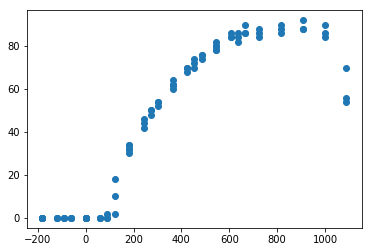

In [63]:
dataFolder = "Dlx12.1\\"
data = pd.read_csv("data.csv")

#Initialize results dataframe
resultsColumns = ['Cell_ID','RMP','Rin','Tau','Rheobase','Spike_Threshold','Spike_Height','Spike_HalfWidth','MaxFiringFrequency','Adaptation', 'AHP_amplitude', 'VoltageSag']
results = pd.DataFrame(columns=resultsColumns)

for cellID in np.unique(data.Cell_ID):
    neuron=data[data.Cell_ID==cellID]

    # Initialise dataframe for single cell data 
    cols=['CommandDuration','CommandAmplitude','RMP','FiringFrequency','VoltageSag','V_Ih_SS','Rheobase','Threshold','SpikeHeight','SpikeHalfWidth','fAHPamplitude','Adaptation']
    neuronResults=pd.DataFrame(columns=cols)

    for i, file in enumerate(neuron.filename):
        abf = pyabf.ABF(dataFolder+"\\"+file)
    
        for sweep in range(abf.sweepCount):    
            #Set voltage, current, time
            abf.setSweep(sweepNumber=sweep, channel=0)
            t = abf.sweepX
            V = abf.sweepY
            abf.setSweep(sweepNumber=sweep, channel=1)
            I = abf.sweepY
            sr = abf.dataRate
    
            if neuron.filetype[i]=='IntrinsicProfile':  
                neuronResults.loc[len(neuronResults), :] = Analyse_IntrinsicProfile(V,I,t,sr)
    
            elif neuron.filetype[i]=='Rin':
                Rin, Tau = Analyse_Rin(V, I, t, sr)
        
            elif neuron.filetype[i]=='Baseline':
                RMP, rheobase, AP_threshold, AP_spikeHeight, AP_halfWidth, AP_fAHP = Analyse_Baseline(V, I, t, sr)
                    
    
    #Build output dataframe  
    results.loc[len(results), :] = [cellID, RMP, Rin, Tau, rheobase, AP_threshold, AP_spikeHeight, AP_halfWidth, np.max(neuronResults.FiringFrequency), neuronResults.Adaptation[neuronResults.FiringFrequency.astype('float64').idxmax()], AP_fAHP, neuronResults.VoltageSag[np.argmin(abs(neuronResults.V_Ih_SS+100))[0]]]
    print(results)
    plt.plot(neuronResults.CommandAmplitude,neuronResults.FiringFrequency,'o')

In [62]:
print(neuronResults.VoltageSag[np.argmin(abs(neuronResults.V_Ih_SS+100))[0]])

1.4648438


In [ ]:
#Plot useful stuff
    fig=plt.figure(figsize=(16, 10))
    ax1 = fig.add_subplot(211)
    ax1.plot(t,V)
    #ax2 = fig.add_subplot(212)
    #ax2.plot(t,I)
    #ax1.plot(t[I_ON:I_OFF],V[I_ON:I_OFF])


    if np.shape(V_peaks)[0] != 0:
        #ax1.plot(t[I_ON+int(0.04*sr):V_peaks[0]],V[I_ON+int(0.04*sr):V_peaks[0]]) #Zoom for threshold check
        #ax1.plot(t[I_ON+int(0.04*sr):V_peaks[0]+int(0.01*sr)],V[I_ON+int(0.04*sr):V_peaks[0]+int(0.01*sr)]) #Zoom for threshold check
        ax1.plot(t[V_peaks],V[V_peaks],"rx")

    if np.shape(V_peaks)[0] in [1,2,3]:
        ax1.plot(t[Th_idx],V[Th_idx],"rx")
        ax1.plot(t[Half_Start],V[Half_Start],'rx')
        ax1.plot(t[Half_End],V[Half_End],'rx')
        ax1.plot(t[fAHP_idx],V[fAHP_idx],'rx')


        ax2 = fig.add_subplot(212)
        ax2.plot(t[I_ON+int(0.04*sr):V_peaks[0]],dV[I_ON+int(0.04*sr):V_peaks[0]])
        ax2.plot(t[Th_idx],dV[Th_idx],"rx")

        fig2 = plt.figure(figsize=(16, 10))
        plt.plot(V,dV)

    if I_command < 0:
        ax1.plot(t[V_Ih_inst_idx],V[V_Ih_inst_idx],"rx")
        ax1.plot(t[I_OFF],V[I_OFF],"rx")
